In [1]:
import pickle
from typing import Callable

import contextily as cx
import folium
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xyzservices.providers as xyz
from shapely import Point
from sklearn.preprocessing import minmax_scale

metadata = {"Author": "Gergő Pintér", "CreationDate": None}
colors = ["#41afaa", "#466eb4", "#00a0e1", "#e6a532", "#d7642c", "#af4b91"]

In [ ]:
CITY = "budapest"

In [ ]:
stops = pd.read_csv(f"../data/stops/{CITY}/stops_gtfs_15min.csv", engine="pyarrow")
stops["geometry"] = stops.apply(lambda x: Point(x["stop_lon"], x["stop_lat"]), axis=1)
stops = gpd.GeoDataFrame(stops, geometry="geometry", crs=4326)
stops.to_crs(23700, inplace=True)
stops.head(3)

stop_id          stop_name   stop_lat   stop_lon stop_code  location_type  \
0  008951           Béke tér  47.430019  19.215675      None            NaN   
1  F03807  Szent László utca  47.441814  19.207651      None            NaN   
2  F03851   Selmecbánya utca  47.438409  19.204790      None            NaN   

  parent_station  wheelchair_boarding  stop_direction  clust  max_distance  \
0         008951                  2.0           -64.0     11           0.0   
1         F03807                  2.0            30.0     12           0.0   
2         F03851                  2.0            29.0     13           0.0   

   quant                       geometry  
0      1  POINT (662691.105 231796.227)  
1      1  POINT (662083.110 233106.253)  
2      1  POINT (661868.082 232727.272)

In [ ]:
with open(f"../data/stops/{CITY}/subgraph_dict_15minute.pkl", "rb") as fp:
    d15m = pickle.load(fp)
with open(f"../data/stops/{CITY}/subgraph_dict_10minute.pkl", "rb") as fp:
    d10m = pickle.load(fp)

In [ ]:
bp = gpd.read_file(
    f"../data/geojson/{CITY}/boundary.geojson",
    engine="pyogrio",
).to_crs(23700)
bp_area = bp.geometry[0]

In [5]:
def get_conneced_stops(stops: gpd.GeoDataFrame, subgraphs: dict, stop: str, at: int):
    connected_stops = list(subgraphs.get(f"{stop}_network_{at}"))
    connected_stops = stops[stops["stop_id"].isin(connected_stops)]
    return connected_stops


def plot_connected_stops(
    connected_stops: gpd.GeoDataFrame,
    stop: gpd.GeoDataFrame,
) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
    connected_stops.plot(
        ax=ax,
        zorder=5,
        color="#2d2d2d",
        markersize=10,
    )
    stop.plot(
        ax=ax,
        zorder=10,
        color=colors[4],
        markersize=50,
    )
    cx.add_basemap(
        ax,
        crs=23700,
        source=cx.providers.CartoDB.VoyagerNoLabels,
        alpha=1,
        attribution=False,
    )
    ax.axis("off")
    ax.margins(0)
    return fig, ax

In [6]:
connected_stops = get_conneced_stops(stops, d10m, "F01006", 39)
f, _ = plot_connected_stops(connected_stops, stops[stops["stop_id"] == "F01006"])
# f.savefig(
#     "../figures/kalvin_10m_connections.png",
#     dpi=120,
#     pad_inches=0,
#     facecolor="white",
#     bbox_inches="tight",
#     metadata=metadata,
# )

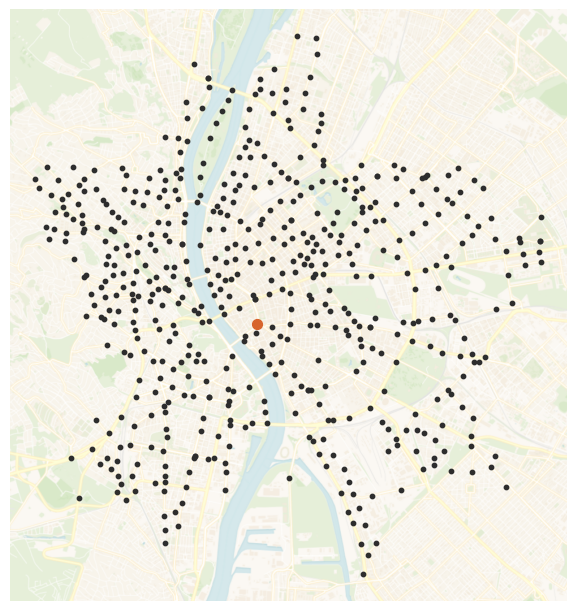

In [7]:
connected_stops = get_conneced_stops(stops, d15m, "F01006", 39)
f, _ = plot_connected_stops(connected_stops, stops[stops["stop_id"] == "F01006"])
# f.savefig(
#     "../figures/kalvin_15m_connections.png",
#     dpi=120,
#     pad_inches=0,
#     facecolor="white",
#     bbox_inches="tight",
#     metadata=metadata,
# )

In [7]:
def compute_ellipticity(points):
    """
    Compute ellipticity of a set of points.

    Parameters:
    - points (numpy array): Array of shape (n, 2) representing (x, y) coordinates of points.

    Returns:
    - ellipticity (float): Ellipticity value.
    """

    # Calculate the covariance matrix of the points
    cov_matrix = np.cov(points, rowvar=False)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Major and minor axis lengths are square roots of eigenvalues
    major_axis_length = np.sqrt(eigenvalues[0])
    minor_axis_length = np.sqrt(eigenvalues[1])

    # Compute ellipticity
    ellipticity = 1.0 - (minor_axis_length / major_axis_length)

    return ellipticity


def compute_eccentricity(points):
    """
    Compute eccentricity of a set of points.

    Parameters:
    - points (numpy array): Array of shape (n, 2) representing (x, y) coordinates of points.

    Returns:
    - eccentricity (float): eccentricity value.
    """

    # Calculate the covariance matrix of the points
    cov_matrix = np.cov(points, rowvar=False)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Major and minor axis lengths are square roots of eigenvalues
    major_axis_length = np.sqrt(eigenvalues[0])
    minor_axis_length = np.sqrt(eigenvalues[1])

    # Compute ellipticity
    eccentricity = np.sqrt(1.0 - (minor_axis_length**2 / major_axis_length**2))

    return eccentricity


def ellipticity(points: list[Point], threshold: int = 10, decimals: int = 4):
    points = [(i.x, i.y) for i in points]
    if len(points) < threshold:
        return None

    return np.round(compute_ellipticity(points), decimals)


def eccentricity(points: list[Point], threshold: int = 10, decimals: int = 4):
    points = [(i.x, i.y) for i in points]
    if len(points) < threshold:
        return None

    return np.round(compute_eccentricity(points), decimals)

In [9]:
eccentricity(connected_stops["geometry"].tolist())

0.4119

In [10]:
ellipticity(connected_stops["geometry"].tolist())

0.0888

In [8]:
def calculate_ellipticity(
    stops: gpd.GeoDataFrame,
    subgraphs: dict,
    at: int,
    func: Callable = ellipticity,
    column: str = "ellipticity",
) -> pd.DataFrame:
    records = []
    for i in stops["stop_id"].tolist():
        if f"{i}_network_{at}" not in subgraphs:
            continue

        connected_stops = get_conneced_stops(stops, subgraphs, i, at)
        e = func(connected_stops["geometry"].tolist())
        records.append([i, e])
    return pd.DataFrame.from_records(records, columns=["stop_id", column])

In [9]:
ellipticity_df = calculate_ellipticity(stops, d15m, 40)

In [10]:
eccentricity_df = calculate_ellipticity(
    stops,
    d15m,
    40,
    func=eccentricity,
    column="eccentricity",
)

In [ ]:
ellipticity_df.to_csv(f"../output/{CITY}/ellipticity.csv", index=False)

In [14]:
to_plot_el = stops.merge(ellipticity_df, on="stop_id", how="left").sort_values(
    "ellipticity", ascending=True
)
fig, ax = plt.subplots(figsize=(7, 7))
bp.plot(ax=ax, fc="none", ec="#2d2d2d")
gpd.clip(to_plot_el, bp_area).plot(
    column="ellipticity",
    legend=True,
    legend_kwds={"shrink": 0.7},
    markersize=minmax_scale(
        gpd.clip(to_plot_el, bp_area)["ellipticity"], feature_range=(1, 16)
    ),
    # cmap="PiYG_r",
    cmap="RdYlBu_r",
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=23700,
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)
ax.axis("off")
ax.margins(0)
for i in ["png", "pdf"]:
    fig.savefig(
        f"../abstract/figures/ellipticity_40.{i}",
        dpi=300,
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0.1,
        metadata=metadata,
    )

In [15]:
bins = jenkspy.jenks_breaks(
    to_plot_el.query("ellipticity.notna()")["ellipticity"], n_classes=6
)
bins

[0.0099, 0.1877, 0.3003, 0.4071, 0.5142, 0.6339, 0.9014]

In [25]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax.set_ylim([221000, 256000])
ax.set_xlim([640750, 675750])
bp.plot(ax=ax, fc="none", ec="#2d2d2d")
gpd.clip(to_plot_el, bp_area).query("ellipticity.notna()").plot(
    column="ellipticity",
    legend=True,
    cmap="RdYlBu_r",
    ax=ax,
    scheme="UserDefined",
    classification_kwds=dict(
        bins=bins[1:],
    ),
    markersize=minmax_scale(
        gpd.clip(to_plot_el, bp_area).query("ellipticity.notna()")["ellipticity"],
        feature_range=(2, 18),
    ),
)
cx.add_basemap(
    ax,
    crs=23700,
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)
ax.margins(0)
ax.axis("off")
for i in ["png", "pdf"]:
    fig.savefig(
        f"../abstract/figures/ellipticity_40_jenks.{i}",
        dpi=300,
        facecolor="white",
        bbox_inches="tight",
        pad_inches=0,
        metadata=metadata,
    )

In [22]:
to_plot_el[["stop_id", "stop_name", "ellipticity", "max_distance", "geometry"]].to_file(
    "../output/ellipticity_39.geojson"
)

In [23]:
to_plot_ec = stops.merge(eccentricity_df, on="stop_id", how="left").sort_values(
    "eccentricity", ascending=False
)
fig, ax = plt.subplots(figsize=(7, 7))
to_plot_ec.plot(
    column="eccentricity",
    legend=True,
    legend_kwds={"shrink": 0.7},
    markersize=minmax_scale(to_plot_ec["eccentricity"], feature_range=(1, 16)),
    # cmap="PiYG_r",
    cmap="RdYlBu_r",
    ax=ax,
)
ax.axis("off")
ax.margins(0)
fig.savefig(
    "../figures/eccentricity_39.png",
    dpi=300,
    facecolor="white",
    bbox_inches="tight",
    pad_inches=0.1,
    metadata=metadata,
)

In [24]:
to_plot_ec[
    ["stop_id", "stop_name", "eccentricity", "max_distance", "geometry"]
].to_file("../output/eccentricity_39.geojson")

In [25]:
to_plot_el_f = (
    to_plot_el.query("ellipticity.notna()")
    .drop_duplicates(subset=["stop_id"])
    .reset_index(drop=True)[
        ["stop_id", "stop_name", "ellipticity", "max_distance", "geometry"]
    ]
    .copy()
)
to_plot_el_f["geometry"] = to_plot_el_f["geometry"].buffer(75)


to_plot_el_f["max_distance"] = to_plot_el_f["max_distance"].apply(lambda x: round(x))

bins_el = jenkspy.jenks_breaks(to_plot_el_f["ellipticity"], n_classes=5)

In [26]:
to_plot_el_f.head(3)

stop_id       stop_name  ellipticity  max_distance  \
0  008447        Dióskert       0.0099             0   
1  F04815     Zrínyi utca       0.0107             0   
2  008326  Ady Endre utca       0.0150            49   

                                            geometry  
0  POLYGON ((639854.931 231303.817, 639854.569 23...  
1  POLYGON ((639754.104 232355.251, 639753.743 23...  
2  POLYGON ((639425.060 232351.283, 639424.699 23...

In [27]:
to_plot_ec_f = (
    to_plot_ec.query("eccentricity.notna()")
    .drop_duplicates(subset=["stop_id"])
    .reset_index(drop=True)[
        ["stop_id", "stop_name", "eccentricity", "max_distance", "geometry"]
    ]
    .copy()
)
to_plot_ec_f["geometry"] = to_plot_ec_f["geometry"].buffer(75)
bins_ec = jenkspy.jenks_breaks(to_plot_ec_f["eccentricity"], n_classes=5)

In [28]:
m = folium.Map(location=[47.5, 19.05], zoom_start=12, tiles=xyz.CartoDB.Voyager)

cp = folium.Choropleth(
    geo_data=to_plot_el_f,
    name="ellipticity",
    data=to_plot_el_f,
    columns=["stop_id", "ellipticity"],
    key_on="feature.properties.stop_id",
    fill_color="RdYlBu_r",
    line_opacity=0.2,
    fill=True,
    fill_opacity=0.85,
    legend_name="ellipticity",
    bins=bins_el,
    nan_fill_color="black",
).add_to(m)

folium.GeoJsonTooltip(["stop_id", "stop_name", "ellipticity"]).add_to(cp.geojson)

# folium.Choropleth(
#     geo_data=to_plot_ec_f,
#     name="eccentricity",
#     data=to_plot_ec_f,
#     columns=["stop_id", "eccentricity"],
#     key_on="feature.properties.stop_id",
#     fill_color="RdYlBu_r",
#     line_opacity=0.2,
#     fill=True,
#     fill_opacity=0.85,
#     legend_name="eccentricity",
#     bins=bins_ec,
#     nan_fill_color="black",
# ).add_to(m)


folium.LayerControl().add_to(m)
m

In [285]:
m.save("../output/ellipticity_39.html")